# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle
import re
import shap


/home/pavan/Ds/pro/Amazon_Alexa_Reviews/Sentiment-Analysis-main/amazon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%pip install wordcloud
from wordcloud import WordCloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
### Exploratory Data Analysis
data = pd.read_csv("./Data/amazon_alexa.tsv", delimiter='\t', quoting=3)
print(f"Dataset shape: {data.shape}")

Dataset shape: (3150, 5)


In [5]:
# Check for null values
print(data.isnull().sum())

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [6]:
# Drop null records
data.dropna(inplace=True)
print(f"Dataset shape after dropping null records: {data.shape}")

Dataset shape after dropping null records: (3149, 5)


In [7]:
# add 'Length' Column
data['length'] = data['verified_reviews'].apply(len)

In [8]:
#Column anmes
print(f"Feature names: {data.columns.values}")

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback' 'length']


#### Analyzing 'rating' column

Rating value count:
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


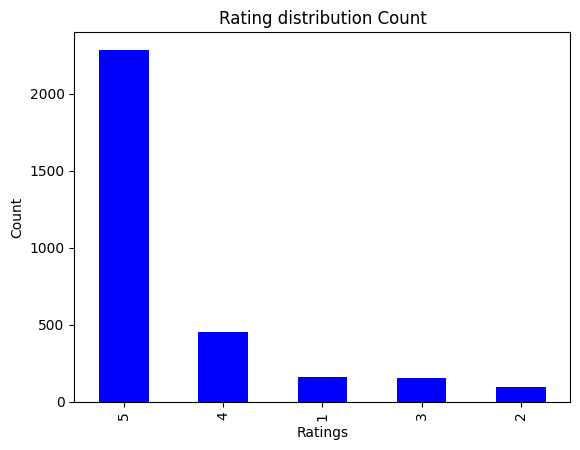

In [9]:
print(f"Rating value count:\n{data['rating'].value_counts()}")
data['rating'].value_counts().plot.bar(color='blue')
plt.title('Rating distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

Rating Value Count - percentage distribution: rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: count, dtype: float64


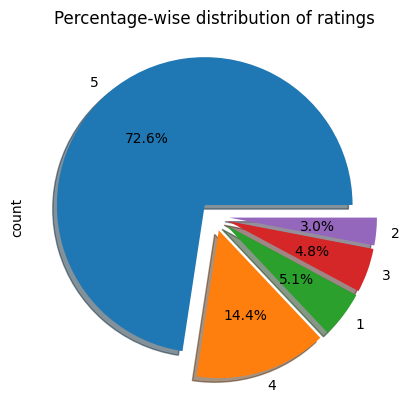

In [10]:
# Percentage distribution of ratings
rating_percent = data['rating'].value_counts() / data.shape[0] * 100
print(f"Rating Value Count - percentage distribution: {rating_percent}")
rating_percent.plot.pie(autopct = "%1.1f%%", shadow= True, color=['red','green','blue','yellow','orange'], explode=[0.1]*5)
plt.title('Percentage-wise distribution of ratings')
plt.show()

#### Analyzing 'feedback' column

Feedback value count:
 feedback
1    2893
0     256
Name: count, dtype: int64


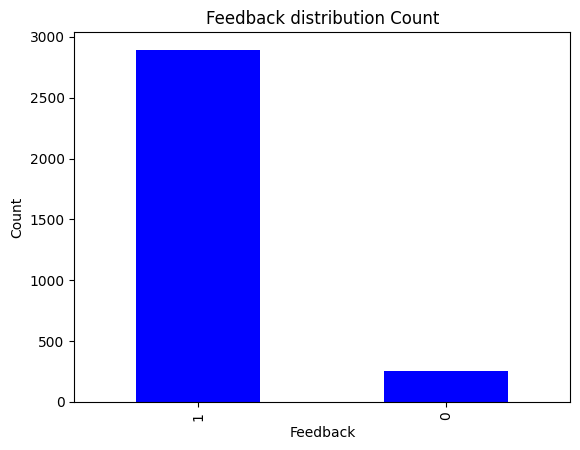

In [11]:
print(f"Feedback value count:\n {data['feedback'].value_counts()}")
data['feedback'].value_counts().plot.bar(color=['blue'])
plt.title('Feedback distribution Count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

- Ratio of the classification variable it is a imbalance variable
- might imbalance dataset if it the target variable

Feedback va;ue count - percentage distribution: 
 feedback
1    91.870435
0     8.129565
Name: count, dtype: float64


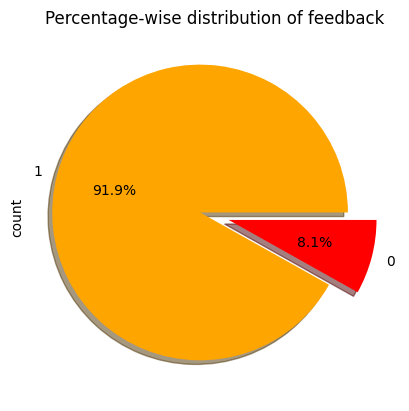

In [12]:
# Percentage distribution of feedback variable
feedback_percent = data['feedback'].value_counts() / data.shape[0] * 100
print(f"Feedback va;ue count - percentage distribution: \n {feedback_percent}")
feedback_percent.plot.pie(autopct = '%1.1f%%', shadow = True, colors = ['orange', 'red'], explode = [0.1] * 2)
plt.title('Percentage-wise distribution of feedback')
plt.show()

Rating distribution for feedback = 0 (negative):
 rating
1    161
2     95
Name: count, dtype: int64
Rating distribution for feedback = 1 (positive):
 rating
5    2286
4     455
3     152
Name: count, dtype: int64
------------------------------------------------------------


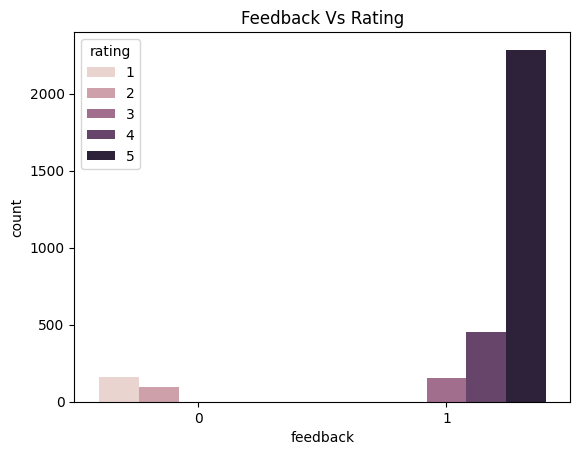

In [13]:
# Relationship between rating and feedback variable
print("Rating distribution for feedback = 0 (negative):\n", data[data['feedback'] == 0]['rating'].value_counts())
print("Rating distribution for feedback = 1 (positive):\n", data[data['feedback'] == 1]['rating'].value_counts())

print("-" *60)
sns.countplot(x='feedback', hue='rating', data=data)
plt.title('Feedback Vs Rating')
plt.show()

#### Analyzing 'variation' column

Variation value count:
 variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


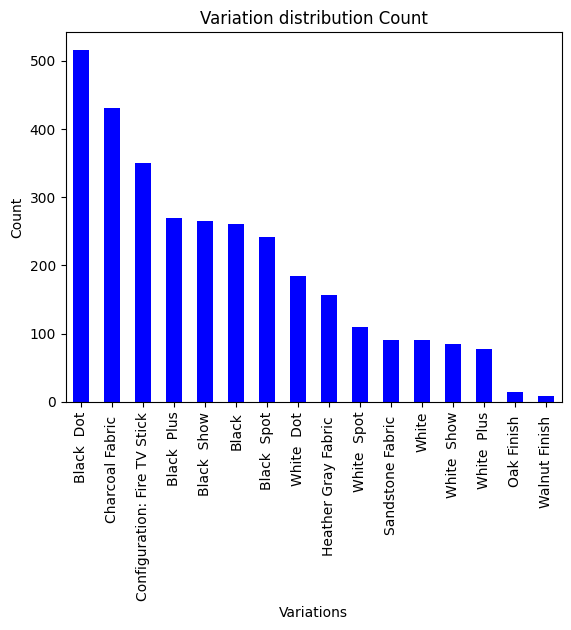

In [14]:

print(f"Variation value count:\n {data['variation'].value_counts()}")
data['variation'].value_counts().plot.bar(color='blue')
plt.title('Variation distribution Count')
plt.xlabel('Variations')
plt.ylabel('Count')
plt.show()


Mean rating by variation: 
 variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64


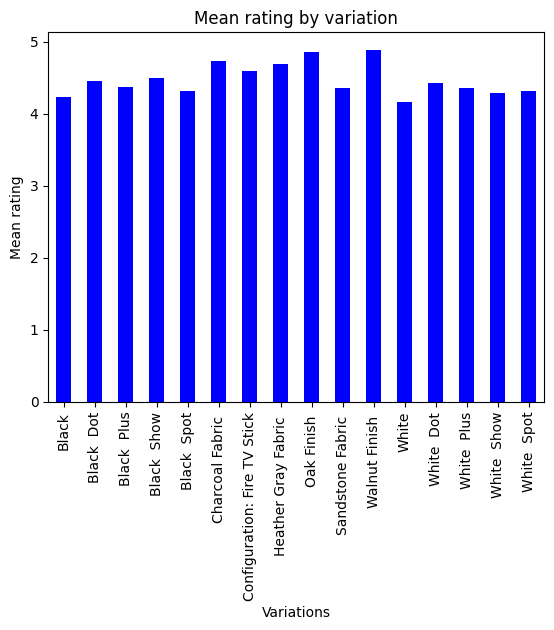

In [15]:
# mean rating by variation
mean_rating_by_variation = data.groupby('variation')['rating'].mean()
print('Mean rating by variation: \n', mean_rating_by_variation)
mean_rating_by_variation.plot.bar(color='blue')
plt.title('Mean rating by variation')
plt.xlabel('Variations')
plt.ylabel('Mean rating')
plt.show()

#### Analyzing 'verified_reviews' column

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64


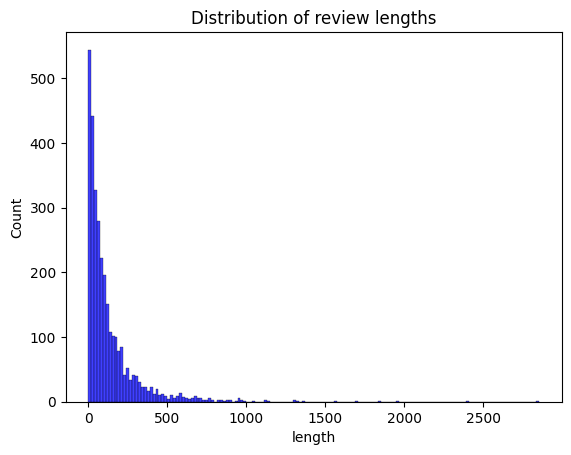

In [16]:
# Length analysis
print(data['length'].describe())
sns.histplot(data['length'], color='blue').set(title = 'Distribution of review lengths')
plt.show()

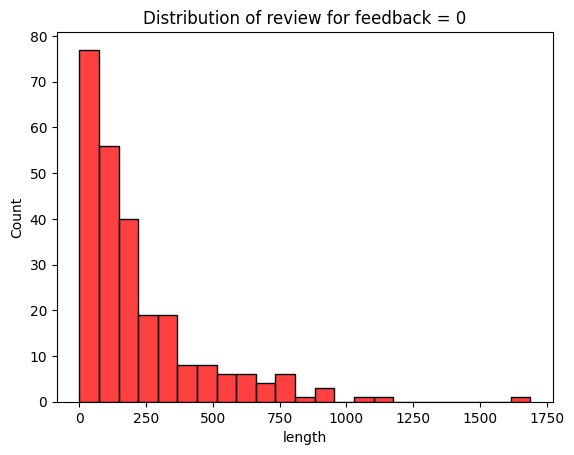

In [17]:
# Length analysis for feedback = 0 (negative)
# print(f"Distribution of review for feedback = 0 :\n {data[data['feedback'] == 0 ]['length'].value_counts( sort=True)[:10]}")
sns.histplot(data[data['feedback'] == 0 ]['length'], color='red').set(title = 'Distribution of review for feedback = 0')
plt.show()

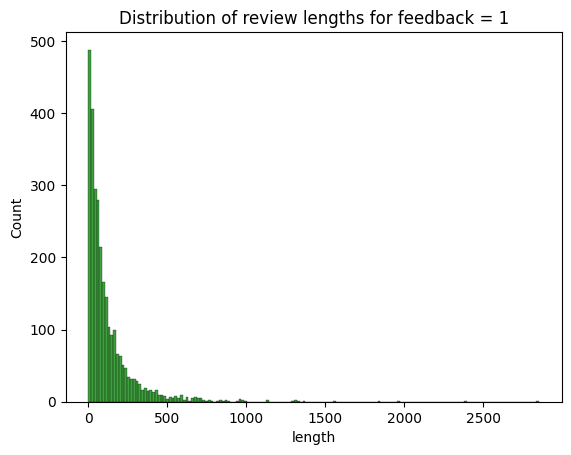

In [18]:
# Length analysis for feedback = 1 (positive)
sns.histplot(data[data['feedback'] == 1]['length'], color='green').set(title='Distribution of review lengths for feedback = 1')
plt.show()

##### word cloud for all reviews

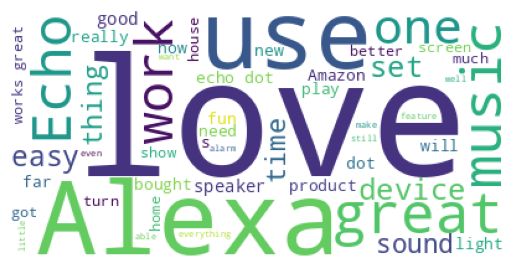

Word Cloud for all reviews


In [19]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])
wordcloud_all = WordCloud(background_color='white', max_words=50).generate("".join(data['verified_reviews']))
plt.imshow(wordcloud_all)



# plt.title(' Word Cloud for all reviews')
plt.axis('off')
plt.show()

print('Word Cloud for all reviews')

In [20]:
# Unique words in each feedback category
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']]).lower().split()
pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']]).lower().split()

In [21]:
unique_negative = " ".join([x for x in neg_reviews if x not in pos_reviews])
unique_positive = " ".join([x for x in pos_reviews if x not in neg_reviews])

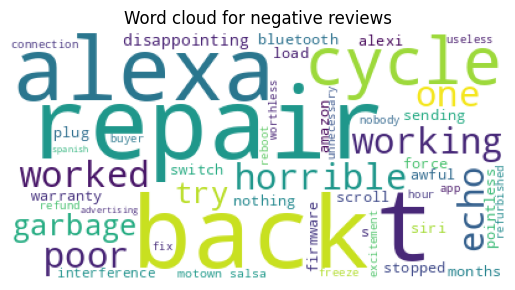

In [22]:
# Word cloud for negative reviews
wordcloud_neg = WordCloud(background_color='white', max_words=50).generate(unique_negative)
plt.imshow(wordcloud_neg)
plt.title('Word cloud for negative reviews')
plt.axis('off')
plt.show()

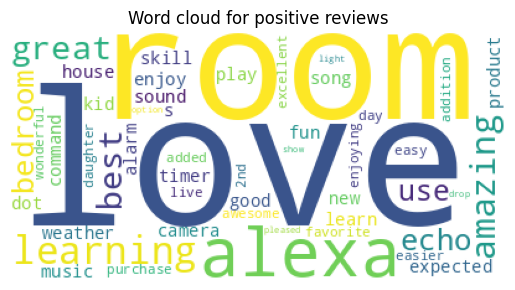

In [23]:
# Word cloud for positive reviews
wordcloud_pos = WordCloud(background_color='white', max_words=50).generate(unique_positive)
plt.imshow(wordcloud_pos)
plt.title('Word cloud for positive reviews')
plt.axis('off')
plt.show()

### Preprocessing and Modeling

In [24]:
corpus = []
stemmer = PorterStemmer()
for i in range(data.shape[0]):
    # review = re.sub('[a-zA-Z]',' ',data.iloc[i]['verified_reviews']) # removes all letters 
    review = re.sub('[^a-zA-Z]', ' ',data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

# corpus

In [25]:
# Using TF - IDF Vectorizer

tfidf = TfidfVectorizer(max_features = 2500)
X = tfidf.fit_transform(corpus).toarray()
y = data['feedback'].values


In [26]:
# save the vectorizer

pickle.dump(tfidf, open('Models/tfidf_vectorizer.pkl','wb'))


In [27]:
# Split data data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 14)

In [28]:
#Scale features
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)
pickle.dump(scaler, open('Models/scaler.pkl','wb'))

In [29]:
### Class Weighting and Advanced Metrics
# Random Forest with class weighting
model_rf = RandomForestClassifier(class_weight='balanced', random_state = 41)
model_rf.fit(X_train_scl,y_train)


RandomForestClassifier(class_weight='balanced', random_state=41)

In [30]:
# Evaluate model
y_pred_rf = model_rf.predict(X_test_scl)
print('Random Forest Classification Report:\n', classification_report(y_test,y_pred_rf))
print('AUC_ROC:', roc_auc_score(y_test,model_rf.predict_proba(X_test_scl)[:,1]))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.35      0.39        75
           1       0.94      0.96      0.95       870

    accuracy                           0.91       945
   macro avg       0.70      0.65      0.67       945
weighted avg       0.91      0.91      0.91       945

AUC_ROC: 0.9242758620689655


In [31]:
# Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, model_rf.predict_proba(X_test_scl)[:, 1])
optimal_threshold = thresholds[np.argmax(recall >= 0.8)]  
y_pred_tuned = (model_rf.predict_proba(X_test_scl)[:, 1] >= optimal_threshold).astype(int)
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))
print('AUC_ROC:', roc_auc_score(y_test,y_pred_tuned))

Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.92      1.00      0.96       870

    accuracy                           0.92       945
   macro avg       0.46      0.50      0.48       945
weighted avg       0.85      0.92      0.88       945

AUC_ROC: 0.5


/home/pavan/Ds/pro/Amazon_Alexa_Reviews/Sentiment-Analysis-main/amazon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pavan/Ds/pro/Amazon_Alexa_Reviews/Sentiment-Analysis-main/amazon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pavan/Ds/pro/Amazon_Alexa_Reviews/Sentiment-Analysis-main/amazon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [32]:

# # SHAP for error analysis
# explainer = shap.TreeExplainer(model_rf)
# shap_values = explainer.shap_values(X_test_scl)
# shap.summary_plot(shap_values, X_test_scl, feature_names=tfidf.get_feature_names_out())


In [33]:
# XGBoost with scale_pos_weight
model_xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42)
model_xgb.fit(X_train_scl, y_train)

print("Model fitted successfully!")

Model fitted successfully!


In [34]:
# ! pip cache purge
# ! pip uninstall -y scikit-learn
# ! pip install scikit-learn==1.5.2
import xgboost
import sklearn

print("XGBoost version:", xgboost.__version__)
print("Scikit-learn version:", sklearn.__version__)



XGBoost version: 2.1.3
Scikit-learn version: 1.5.2


In [35]:
# import xgboost as xgb

# # Convert data to DMatrix format
# dtrain = xgb.DMatrix(X_train_scl, label=y_train)

# # Set parameters
# params = {
#     "objective": "binary:logistic",  # For binary classification
#     "scale_pos_weight": len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
#     "random_state": 42
# }

# # Train the model
# model_xgb = xgb.train(params, dtrain)

print("Model trained successfully using native XGBoost API!")

Model trained successfully using native XGBoost API!


In [36]:
# Evaluate model
y_pred_xgb = model_xgb.predict(X_test_scl)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, model_xgb.predict_proba(X_test_scl)[:, 1]))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.68      0.37        75
           1       0.97      0.83      0.89       870

    accuracy                           0.81       945
   macro avg       0.61      0.75      0.63       945
weighted avg       0.91      0.81      0.85       945

AUC-ROC: 0.8608812260536398


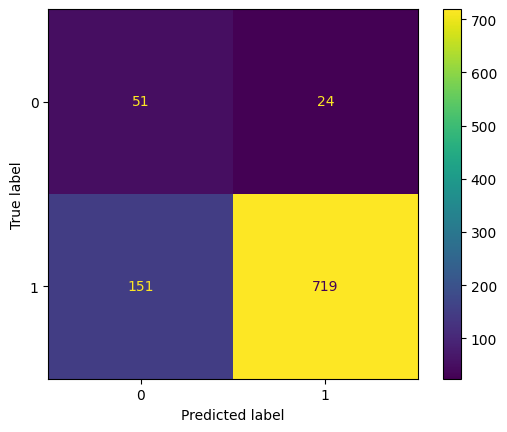

In [37]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [38]:
#Saving the svm classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [39]:

# Resampling pipeline (SMOTE + RandomUnderSampler)
over = SMOTE(sampling_strategy=0.3, random_state=42)  # Increase minority class to 30% of majority
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)  # Reduce majority class to 70%
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_resampled, y_resampled = pipeline.fit_resample(X_train_scl, y_train)


In [40]:


# Model training with class weighting
model_rf = RandomForestClassifier(random_state=41,  max_depth= 8, min_samples_split= 2, n_estimators=100)
model_rf.fit(X_resampled, y_resampled)

# Evaluate model
y_pred_rf = model_rf.predict(X_test_scl)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, model_rf.predict_proba(X_test_scl)[:, 1]))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.19      0.30        75
           1       0.93      0.99      0.96       870

    accuracy                           0.93       945
   macro avg       0.84      0.59      0.63       945
weighted avg       0.92      0.93      0.91       945

AUC-ROC: 0.8824521072796935


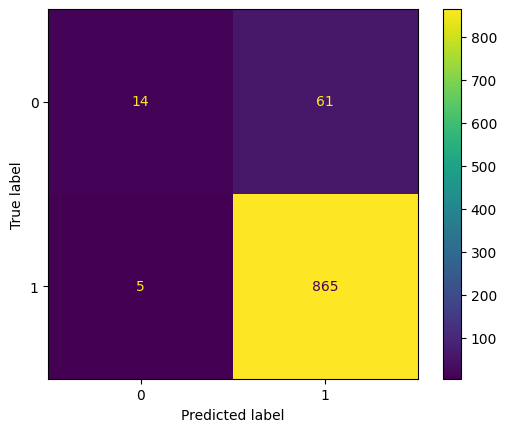

In [41]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [42]:
#Saving the rf classifier
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

In [45]:
# Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [7,8,10, 50, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'class_weight': ['balanced', None]  # Handle class imbalance
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Focus on F1-score for imbalanced data
    
)

grid_search_rf.fit(X_resampled, y_resampled)

# Best parameters and score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best F1-Score:", grid_search_rf.best_score_)

y_pred_tuned = (grid_search_rf.predict_proba(X_test_scl)[:, 1] >= optimal_threshold).astype(int)
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_tuned))



Best Parameters: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-Score: 0.9326434453356173
Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.04      0.08        75
           1       0.92      1.00      0.96       870

    accuracy                           0.92       945
   macro avg       0.84      0.52      0.52       945
weighted avg       0.91      0.92      0.89       945



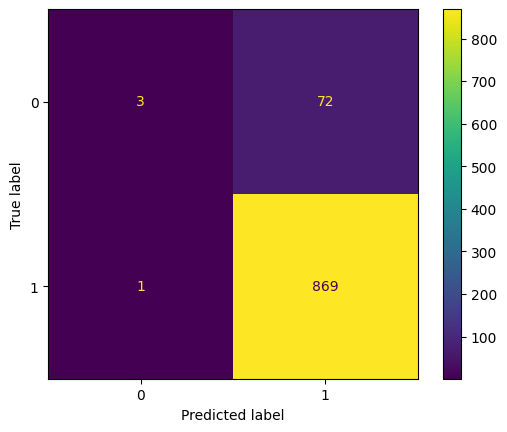

In [46]:
cm = confusion_matrix(y_test, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

Before Counter({1: 2023, 0: 181})
after Counter({1: 2023, 0: 2023})
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.57      0.45        75
           1       0.96      0.92      0.94       870

    accuracy                           0.89       945
   macro avg       0.67      0.75      0.70       945
weighted avg       0.91      0.89      0.90       945

AUC-ROC: 0.8950881226053641


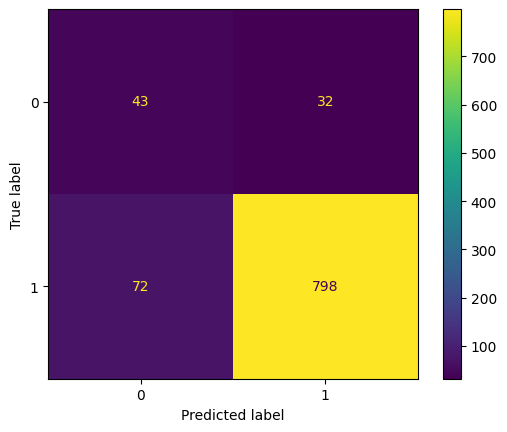

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.65      0.42        75
           1       0.97      0.87      0.92       870

    accuracy                           0.85       945
   macro avg       0.64      0.76      0.67       945
weighted avg       0.91      0.85      0.88       945

AUC-ROC: 0.8773639846743295


In [47]:

from collections import Counter
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before', counter)



# Oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train_scl, y_train)

counter = Counter(y_train_smtom)
print('after', counter)

# Train XGBoost on the resampled data
model_xgb = XGBClassifier()
model_xgb.fit(X_train_smtom, y_train_smtom)

# Evaluate the model
y_pred_xgb = model_xgb.predict(X_test_scl)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, model_xgb.predict_proba(X_test_scl)[:, 1]))

cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()



# Train XGBoost on the resampled data
model_xgb = XGBClassifier()
model_xgb.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred_xgb = model_xgb.predict(X_test_scl)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, model_xgb.predict_proba(X_test_scl)[:, 1]))

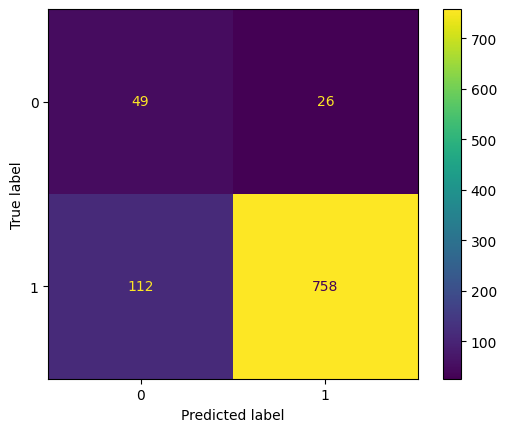

In [48]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [2,3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50,100, 200, 300],
    'gamma': [0, 1, 2]
}

grid_search = GridSearchCV(estimator=XGBClassifier(),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           verbose=1)
grid_search.fit(X_resampled, y_resampled)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.68      0.42        75
           1       0.97      0.87      0.91       870

    accuracy                           0.85       945
   macro avg       0.64      0.77      0.67       945
weighted avg       0.92      0.85      0.88       945

AUC-ROC: 0.8839003831417626


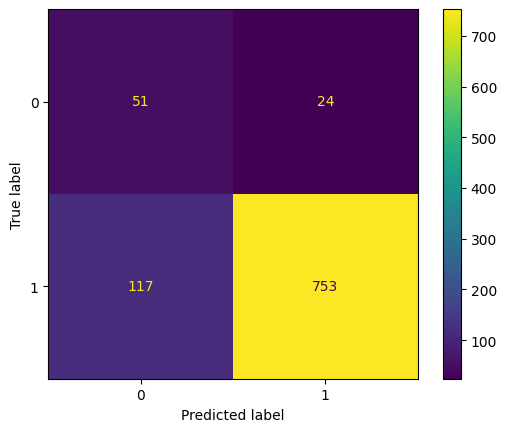

In [50]:
# Evaluate the model
y_pred_xgb = grid_search.predict(X_test_scl)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, grid_search.predict_proba(X_test_scl)[:, 1]))

cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()


In [54]:
#Saving the xgboost classifier
pickle.dump(grid_search, open('Models/model_xgb.pkl', 'wb'))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.77      0.39        75
           1       0.98      0.81      0.89       870

    accuracy                           0.81       945
   macro avg       0.62      0.79      0.64       945
weighted avg       0.92      0.81      0.85       945

SVM AUC-ROC: 0.7941


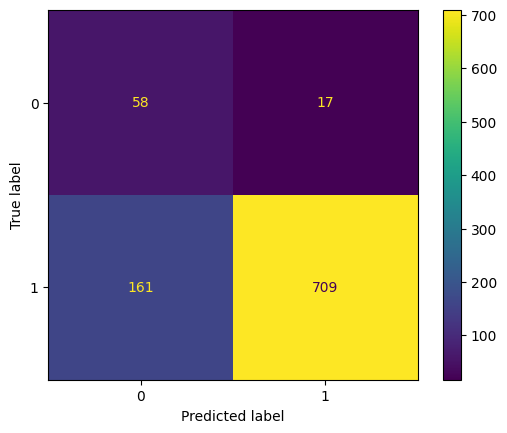

In [51]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

# Feature scaling for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_scl)
X_test_scaled = scaler.transform(X_test)

# Configure SVM with class weights
svm_model = SVC(
    
    kernel='sigmoid',  # Better for high-dimensional data
    C=0.5,
    gamma='scale',
    probability=True,
    random_state=42
)

# # Calibration for better probability estimates
# calibrated_svm = CalibratedClassifierCV(svm_model, method='isotonic', cv=3)
svm_model.fit(X_resampled, y_resampled)

# Predict with optimal threshold
# svm_probs = svm_model.predict_proba(X_test_scaled)[:, 0]
# svm_pred = (svm_probs >= optimal_threshold).astype(int)  # Use same threshold as XGBoost
svm_pred = svm_model.predict(X_test)

# Evaluation
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))
print(f"SVM AUC-ROC: {roc_auc_score(y_test, svm_pred):.4f}")

cm = confusion_matrix(y_test, svm_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()



In [52]:
#Saving the svm classifier
pickle.dump(svm_model, open('Models/svm_model.pkl', 'wb'))

#### different

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import nltk


# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')



# Custom text cleaner with lemmatization
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.token_pattern = re.compile(r'(?u)\b\w\w+\b') 
        
    def clean_text(self, data):
        corpus = []
        for i in range(data.shape[0]):
            review =  re.sub('[^a-zA-Z]', ' ',data.iloc[i]['verified_reviews'])
            review = review.lower()
             # Proper tokenization
            words = self.token_pattern.findall(review)
            words = [self.lemmatizer.lemmatize(word) for word in words 
                    if word not in self.stop_words and len(word) > 2]
            corpus.append(' '.join(words))
        return corpus


[nltk_data] Downloading package stopwords to /home/pavan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pavan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:
#  Apply preprocessing
preprocessor = TextPreprocessor()
corpus_clean = []
corpus_clean = preprocessor.clean_text(data) 

# TF-IDF with n-grams
tfidf = TfidfVectorizer(
    max_features=2500,
    ngram_range=(1,3),  # Try tri-grams
    analyzer='word',     # Combine word and char features
    min_df=5,            # Ignore rare terms
    stop_words='english'
)

X = tfidf.fit_transform(corpus_clean).toarray()
y = data['feedback'].values

print(X[1],':',y[1])
print('-----------------------')
print(X[45],':',y[45])
print('-----------------------')
print(X[46],':',y[46])

print(len(X)," ", len(y))

[0. 0. 0. ... 0. 0. 0.] : 1
-----------------------
[0. 0. 0. ... 0. 0. 0.] : 1
-----------------------
[0. 0. 0. ... 0. 0. 0.] : 0
3149   3149


In [120]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Split data before any resampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=15, stratify=y
)

# Apply SMOTEENN resampling
smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.5)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

In [121]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, auc
import numpy as np

# Custom scoring function for minority class F1
def f1_minority(y_true, y_pred):
    return f1_score(y_true, y_pred, labels=[0], average='micro')

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2,0.4,0.6,0.8,1.0,1.4,1.6,1.8,2],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [0,1,2,5, 10, 15],
    'gamma': [0, 0.1, 0.2,0.5,1.0,0.8,1.5,2.0]
}

# Initialize model
xgb = XGBClassifier(n_estimators=200, random_state=42)

# Randomized search with PR-AUC scoring
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train_res, y_train_res)

# Get best model
best_xgb = search.best_estimator_

best_xgb

Fitting 5 folds for each of 20 candidates, totalling 100 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [122]:
# Get predicted probabilities
y_proba = best_xgb.predict_proba(X_test)[:, 0]

# Find optimal threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba, pos_label=0)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Apply optimal threshold
y_pred = (y_proba >= optimal_threshold).astype(int)

In [123]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print("Optimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

Optimized XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.57      0.10        77
           1       0.79      0.14      0.24       868

    accuracy                           0.18       945
   macro avg       0.42      0.36      0.17       945
weighted avg       0.73      0.18      0.23       945

AUC-ROC: 0.2225
PR-AUC: 0.8543


In [124]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Balanced Bagging Classifier
bbc = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=50,
    random_state=42,
    sampling_strategy='auto',
    replacement=True
)

bbc.fit(X_train_res, y_train_res)
bbc_pred = bbc.predict(X_test)

print("\nBalanced Bagging Classifier Report:")
print(classification_report(y_test, bbc_pred))


Balanced Bagging Classifier Report:
              precision    recall  f1-score   support

           0       0.14      0.94      0.24        77
           1       0.99      0.49      0.65       868

    accuracy                           0.53       945
   macro avg       0.56      0.71      0.45       945
weighted avg       0.92      0.53      0.62       945

